# Calculating calibration densities and plotting models at UCB
- This workbook shows how we calculate densities for calibration data, plot models and calculate the cali lines

In [1]:
# Import useful python packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import math
import os
import datetime

## Downloading DiadFit locally
- The easiest way to install diad fit is by removing the #. It will install from PyPI
- You only need to do this once on each computer, or run in order to grab an updated version. 

### This imports DiadFit, and gives you the version. In all communication with Penny, make sure you say the version!


In [2]:
import DiadFit as pf
pf.__version__

'0.0.59'

## Import the data (after fitting and pressure matching)

In [3]:
caldata=pd.read_excel(r"C:\Users\charl\Documents\Instruments and calibrations\UCB_6-7-23\merged_dataframe.xlsx").drop(columns={'Unnamed: 0'})
caldata.head()

,Corrected_Splitting,Corr_Split+1σ,Corr_Split-1σ,Corr_Split_1σ_val,filename_x,Splitting,Split_err_abs,Split_err_quadrature,Diad1_Combofit_Cent,Diad1_cent_err,...,Date and Time - offset,unix_timestamp,duration_s,start_time_P,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr
0,105.339288,105.342918,105.335657,0.003631,FDCA-P1-1,105.593247,0.004914,0.003590,1281.208360,0.003096,...,2023-06-07 13:27:21,1686144441,52,2023-06-07 13:27:20.975,2023-06-07 13:28:12.975,66.463879,0.000959,32.336914,0.001013,FDCA-P1-1
1,105.343871,105.347321,105.340420,0.003450,FDCA-P1-2_CRR_DiadFit,105.597889,0.004678,0.003407,1281.204059,0.002916,...,2023-06-07 13:28:20,1686144500,51,2023-06-07 13:28:20.971,2023-06-07 13:29:11.971,66.460425,0.001139,32.340820,0.000777,FDCA-P1-2
2,105.342879,105.346483,105.339274,0.003604,FDCA-P1-3,105.596941,0.004878,0.003564,1281.205792,0.003072,...,2023-06-07 13:29:18,1686144558,51,2023-06-07 13:29:17.971,2023-06-07 13:30:08.971,66.455936,0.001092,32.343750,0.001061,FDCA-P1-3
3,105.281586,105.284978,105.278193,0.003393,FDCA-P2-1,105.536177,0.004601,0.003348,1281.291375,0.002860,...,2023-06-07 13:43:44,1686145424,52,2023-06-07 13:43:44.974,2023-06-07 13:44:36.974,60.179294,0.001203,32.389160,0.001302,FDCA-P2-1
4,105.279822,105.283322,105.276322,0.003500,FDCA-P2-2_CRR_DiadFit,105.534458,0.004741,0.003458,1281.291815,0.002970,...,2023-06-07 13:44:50,1686145490,51,2023-06-07 13:44:50.970,2023-06-07 13:45:41.970,60.178839,0.001778,32.392578,0.000977,FDCA-P2-2


In [4]:
manualdata=pd.read_excel(r"C:\Users\charl\Documents\Instruments and calibrations\UCB_6-7-23\Experiment_37C_6-7-23.xlsx")
manualdata.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,T4_manual,Unnamed: 11
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,66.4600,36.970,36.970,36.970,36.970,36.970,2.10
1,FDCA-P1-2,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,36.970,NaN
2,FDCA-P1-3,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,36.970,NaN
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,60.1811,36.974,36.975,36.976,36.976,36.976,2.15
4,FDCA-P2-2,NaN,NaN,NaN,NaN,60.1815,36.976,36.977,36.978,36.979,36.979,NaN


In [5]:
merged_df = pd.merge(right=caldata, left=manualdata, right_on='filename_nocrr',left_on='Label')
merged_df.to_clipboard(excel=True)

In [6]:
#creates a column with a new column that splits the filename to sample name (FDCA-P1-1 becomes FDCA-P1)
merged_df['filename_split'] = merged_df['filename_x'].str.split('-', n=2).str[:2].str.join('-')
merged_df.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,unix_timestamp,duration_s,start_time_P,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr,filename_split
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,66.4600,36.970,36.970,36.970,36.970,...,1686144441,52,2023-06-07 13:27:20.975,2023-06-07 13:28:12.975,66.463879,0.000959,32.336914,0.001013,FDCA-P1-1,FDCA-P1
1,FDCA-P1-2,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,1686144500,51,2023-06-07 13:28:20.971,2023-06-07 13:29:11.971,66.460425,0.001139,32.340820,0.000777,FDCA-P1-2,FDCA-P1
2,FDCA-P1-3,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,1686144558,51,2023-06-07 13:29:17.971,2023-06-07 13:30:08.971,66.455936,0.001092,32.343750,0.001061,FDCA-P1-3,FDCA-P1
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,60.1811,36.974,36.975,36.976,36.976,...,1686145424,52,2023-06-07 13:43:44.974,2023-06-07 13:44:36.974,60.179294,0.001203,32.389160,0.001302,FDCA-P2-1,FDCA-P2
4,FDCA-P2-2,NaN,NaN,NaN,NaN,60.1815,36.976,36.977,36.978,36.979,...,1686145490,51,2023-06-07 13:44:50.970,2023-06-07 13:45:41.970,60.178839,0.001778,32.392578,0.000977,FDCA-P2-2,FDCA-P2


## Calculate mean T

In [7]:
merged_df['T_C_mean'] = merged_df[['T0_manual', 'T1_manual', 'T2_manual', 'T3_manual', 'T4_manual']].replace(0, np.nan).mean(axis=1, skipna=True)
merged_df['T_C_std'] = merged_df[['T0_manual', 'T1_manual', 'T2_manual', 'T3_manual', 'T4_manual']].replace(0, np.nan).std(axis=1, skipna=True)

merged_df['rho_gmL']=pf.calculate_rho_for_P_T(P_kbar=np.array(merged_df['median_pressure']/100),
                                               T_K=np.array(merged_df['T_C_mean']+273.15), EOS='SW96')

merged_df.to_clipboard(excel=True)
merged_df.to_excel(r"C:\Users\charl\Documents\Instruments and calibrations\UCB_6-7-23"+'/'+'merged_df_wrho.xlsx')
merged_df.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,end_time_P,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr,filename_split,T_C_mean,T_C_std,rho_gmL
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,66.4600,36.970,36.970,36.970,36.970,...,2023-06-07 13:28:12.975,66.463879,0.000959,32.336914,0.001013,FDCA-P1-1,FDCA-P1,36.9700,0.000000,1.043839
1,FDCA-P1-2,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,2023-06-07 13:29:11.971,66.460425,0.001139,32.340820,0.000777,FDCA-P1-2,FDCA-P1,36.9700,0.000000,1.043831
2,FDCA-P1-3,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,2023-06-07 13:30:08.971,66.455936,0.001092,32.343750,0.001061,FDCA-P1-3,FDCA-P1,36.9700,0.000000,1.043820
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,60.1811,36.974,36.975,36.976,36.976,...,2023-06-07 13:44:36.974,60.179294,0.001203,32.389160,0.001302,FDCA-P2-1,FDCA-P2,36.9754,0.000894,1.028451
4,FDCA-P2-2,NaN,NaN,NaN,NaN,60.1815,36.976,36.977,36.978,36.979,...,2023-06-07 13:45:41.970,60.178839,0.001778,32.392578,0.000977,FDCA-P2-2,FDCA-P2,36.9778,0.001304,1.028444


## Plot of manually recorded pressure vs pressure transducer median and standard deviation over analysis duration

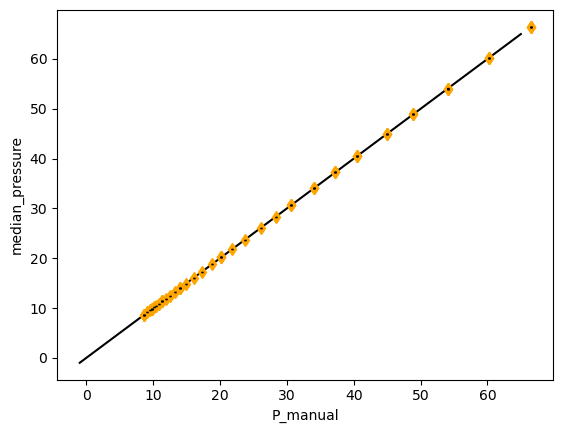

In [8]:
plt.errorbar(y=merged_df['median_pressure'],x=merged_df['P_manual'], yerr=merged_df['mad_pressure'], fmt='d',
             color='orange',mfc='orange', ecolor='black', capsize=1,barsabove=True,zorder=2)

plt.plot([-1, 65], [-1,65], color='black', linestyle='-',zorder=-1)

plt.xlabel('P_manual')
plt.ylabel('median_pressure')
plt.show()

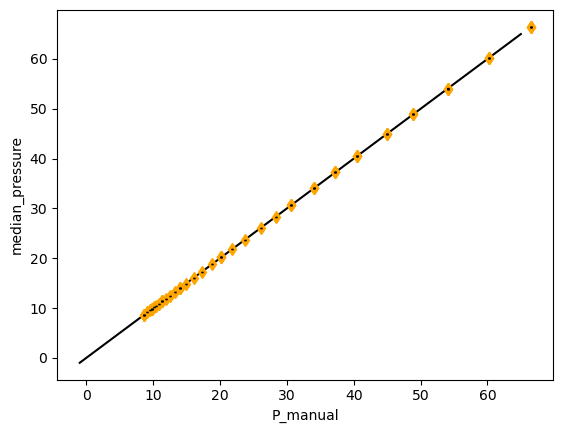

In [9]:
plt.errorbar(y=merged_df['median_pressure'],x=merged_df['P_manual'], yerr=merged_df['mad_pressure'], fmt='d',
             color='orange',mfc='orange', ecolor='black', capsize=1,barsabove=True,zorder=2)

plt.plot([-1, 65], [-1,65], color='black', linestyle='-',zorder=-1)

plt.xlabel('P_manual')
plt.ylabel('median_pressure')
plt.show()

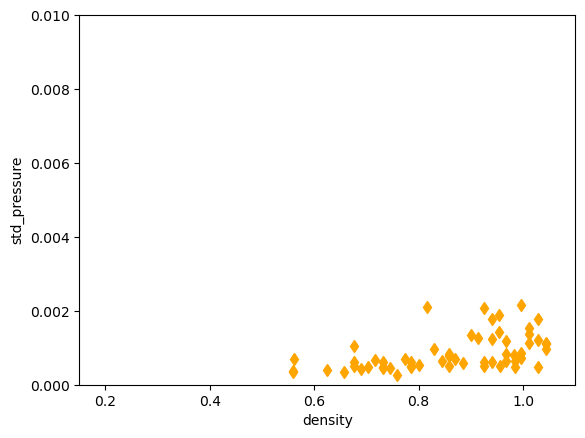

In [20]:
plt.errorbar(y=merged_df['mad_pressure'],x=merged_df['rho_gmL'],  fmt='d',
             color='orange',mfc='orange', ecolor='black', capsize=1,barsabove=True,zorder=2)

# plt.plot([-1, 65], [-1,65], color='black', linestyle='-',zorder=-1)

plt.xlabel('density')
plt.ylabel('std_pressure')
plt.xlim([0.15,1.1])
plt.ylim([0,0.01])
plt.show()

## Plot of density vs fermi splitting

In [18]:
if os.path.exists(r"C:\Users\charl\Desktop\1-s2.0-S0009254121004654-mmc1.xlsx"):
    cornellcell=pd.read_excel(r"C:\Users\charl\Desktop\1-s2.0-S0009254121004654-mmc1.xlsx")

In [15]:
rho_cornell=pf.calculate_density_cornell(temp='SupCrit', Split=merged_df['Corrected_Splitting'])
merged_df['cornellEQ_predrho']=rho_cornell['Preferred D']
merged_df.head()

,Label,P_kbar,T_K,CO2_dens_gcm3,P_Mpa_target,P_manual,T0_manual,T1_manual,T2_manual,T3_manual,...,median_pressure,mad_pressure,median_temp,mad_temp,filename_nocrr,filename_split,T_C_mean,T_C_std,rho_gmL,cornellEQ_predrho
0,FDCA-P1-1,0.648713,310.15,1.040000,64.871318,66.4600,36.970,36.970,36.970,36.970,...,66.463879,0.000959,32.336914,0.001013,FDCA-P1-1,FDCA-P1,36.9700,0.000000,1.043839,1.037140
1,FDCA-P1-2,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,66.460425,0.001139,32.340820,0.000777,FDCA-P1-2,FDCA-P1,36.9700,0.000000,1.043831,1.037963
2,FDCA-P1-3,NaN,NaN,NaN,NaN,66.4600,36.970,36.970,36.970,36.970,...,66.455936,0.001092,32.343750,0.001061,FDCA-P1-3,FDCA-P1,36.9700,0.000000,1.043820,1.037785
3,FDCA-P2-1,0.592398,310.15,1.025959,59.239802,60.1811,36.974,36.975,36.976,36.976,...,60.179294,0.001203,32.389160,0.001302,FDCA-P2-1,FDCA-P2,36.9754,0.000894,1.028451,1.026237
4,FDCA-P2-2,NaN,NaN,NaN,NaN,60.1815,36.976,36.977,36.978,36.979,...,60.178839,0.001778,32.392578,0.000977,FDCA-P2-2,FDCA-P2,36.9778,0.001304,1.028444,1.025888


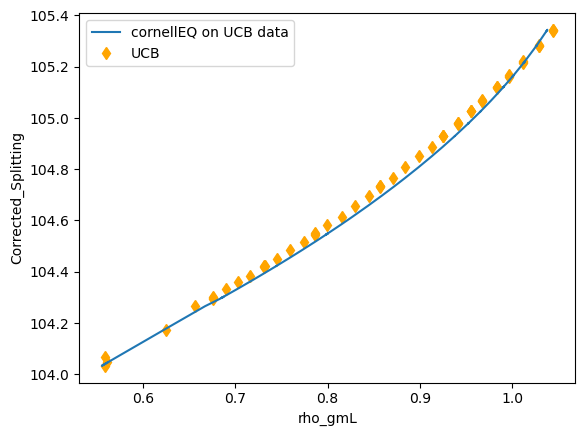

In [17]:
fig,ax=plt.subplots()

x='rho_gmL'
y='Corrected_Splitting'
ax.errorbar(x=merged_df[x],y=merged_df[y], fmt='d',
             color='orange',mfc='orange', ecolor='black', capsize=1,barsabove=True,zorder=2,
           label='UCB')


ax.plot(merged_df['cornellEQ_predrho'],merged_df[y],label='cornellEQ on UCB data')
# ax2=ax.twinx()
# ax2.plot(merged_df['Corrected_Splitting'],merged_df['median_temp'],color='darkred')
# ax2.set_ylabel('Sensor_T')

ax.set_xlabel(x)
ax.set_ylabel(y)
plt.legend()


plt.show()